In [ ]:
## PART 1. Set up the VizWiz-VQA dataset

img_dir = "https://vizwiz.cs.colorado.edu//VizWiz_visualization_img/"
split_train = 'train' 
split_val = 'val'
split_test = 'test'
annotation_file_train = "https://ivc.ischool.utexas.edu/VizWiz_final/vqa_data/Annotations/%s.json" %split_train
annotation_file_val = "https://ivc.ischool.utexas.edu/VizWiz_final/vqa_data/Annotations/%s.json" %split_val
annotation_file_test = "https://ivc.ischool.utexas.edu/VizWiz_final/vqa_data/Annotations/%s.json" %split_test

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.io import imread, imshow

In [ ]:
## Visualize image given a url
from skimage import io
def visualize_image(image_url):
  image = io.imread(image_url)
  print(image_url)
  plt.imshow(image)
  plt.axis("off")
  plt.show()

In [ ]:
# Read the file to extract each dataset example with label
import requests
import numpy as np

split_data_train = requests.get(annotation_file_train, allow_redirects=True)
split_data_val = requests.get(annotation_file_val, allow_redirects=True)
split_data_test = requests.get(annotation_file_test, allow_redirects=True)
train_data = split_data_train.json()
val_data = split_data_val.json()
test_data = split_data_test.json()

In [ ]:
#Create vocabulary
texts=[]
for i in train_data:
  texts.append(i['question'])
vocab = sorted(set(word for sentence in texts for word in sentence.split()))

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
from PIL import Image
import cv2

In [ ]:

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(240, 240, 3))
# VGG16 used for feature extraction 

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0     

In [ ]:
## PART 2: Template code to set up a VQA model

def extract_image_features(image_url):
  imag = imread(image_url) 
  imag = cv2.resize(imag, (240, 240))
  imag = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
  feature_vector = conv_base.predict(imag.reshape(1, 240, 240, 3))
  feature = np.reshape(feature_vector, (25088,))
  return feature


def extract_question_features(question):
  output_vec = np.zeros(len(vocab))
  words_ques = set(question.split())
  for i, v in enumerate(vocab):
      output_vec[i] = v in words_ques 
  return output_vec


In [ ]:
def find_most_frequent(answers):
  all = []
  for i in answers:
    all.append(i['answer'])
  return max(set(all), key = all.count)

In [ ]:
##Extracting validation data

num_val = 544
# X_val = [] ## features
# y_val = [] ## target labels
url_val = []
name_val = []
img_ft_val = []
ques_val = []
ques_ft_val = []
ft_val = []
lab_val = []
for vq in val_data[0:num_val]:
  # Extract features describing the image
  image_name = vq['image']
  name_val.append(image_name)
  image_url = img_dir + image_name
  url_val.append(image_url)
  image_feature = extract_image_features(image_url)
  img_ft_val.append(image_feature)

  # Extract features describing the question
  question = vq['question']
  ques_val.append(question)
  question_feature = extract_question_features(question)
  ques_ft_val.append(question_feature)

  # Create a multimodal feature to represent both the image and question (e.g. concatenate, multiply, etc.)
  multimodal_features = np.concatenate((question_feature, image_feature))
  ft_val.append(multimodal_features)

  # Prepare features and labels
  # X.append(multimodal_features)
  answers = vq['answers']
  label = find_most_frequent(answers)
  lab_val.append(label)
  # y.append(label)


In [ ]:
## Extracting training data

num_val = 4000
# X_val = [] ## features
# y_val = [] ## target labels
url = []
name = []
img_ft = []
ques = []
ques_ft = []
ft = []
lab = []
for vq in val_data[0:num_val]:


  # Prepare features and labels
  answers = vq['answers']
  label = find_most_frequent(answers)
  if label != 'unanswerable' and label!= 'unsuitable':
    lab.append(label)
  # Extract features describing the image
    image_name = vq['image']
    name.append(image_name)
    image_url = img_dir + image_name
    url.append(image_url)
    image_feature = extract_image_features(image_url)
    img_ft.append(image_feature)

  # Extract features describing the question
    question = vq['question']
    ques.append(question)
    question_feature = extract_question_features(question)
    ques_ft.append(question_feature)

  # Create a multimodal feature to represent both the image and question (e.g. concatenate, multiply, etc.)
    multimodal_features = np.concatenate((question_feature, image_feature))
    ft.append(multimodal_features)


In [ ]:
column_names = ["imageName", "url", "question", "image_feature","question_feature","feature", "label"]

df = pd.DataFrame(columns = column_names)

In [ ]:
df.url = url
df.imageName = name
df.question = ques
df.image_feature = img_ft
df.question_feature = ques_ft
df.feature = ft
df.label = lab

In [ ]:
df_val = pd.DataFrame(columns = column_names)

In [ ]:
df_val.url = url_val
df_val.imageName = name_val
df_val.question = ques_val
df_val.image_feature = img_ft_val
df_val.question_feature = ques_ft_val
df_val.feature = ft_val
df_val.label = lab_val

In [ ]:
df_val.to_csv("vizwiz_val.csv")

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
one_hot=pd.get_dummies(df["label"])
onehot_val=pd.get_dummies(df_val["label"])

In [ ]:
X = df['feature']
y = one_hot

In [ ]:
X_val = df_val['feature']
y_val = onehot_val

In [ ]:
X = X.to_list()
y = y.values.tolist()


In [ ]:
X_val = X_val.to_list()
y_val = y_val.values.tolist()

In [ ]:
for i in range(len(X)):
  X[i] = np.asarray(X[i]).astype('float32')

In [ ]:
for i in range(len(X_val)):
  X_val[i] = np.asarray(X_val[i]).astype('float32')

In [ ]:
for i in range(len(y)):
  y[i] = np.asarray(y[i]).astype('float32')

In [ ]:
for i in range(len(y_val)):
  y_val[i] = np.asarray(y_val[i]).astype('float32')

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
##Not using the X_test and y_test anywhere. Using the separately extracted val and test set instead. 

In [ ]:
from tensorflow.keras.optimizers import RMSprop

In [ ]:
import keras

In [ ]:
from keras import Sequential
from keras.layers.core import Dense, Dropout
# from tensorflow.python.keras.optimizers import RMSprop

model = Sequential()

model.add(Dense(10, input_shape=(31893,), activation = "relu"))
model.add(Dense(50, activation = "relu"))
model.add(Dense(1409, activation = "softmax"))

# Print the summary of the model to view the shape and number of parameters
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 10)                318940    
                                                                 
 dense_47 (Dense)            (None, 50)                550       
                                                                 
 dense_48 (Dense)            (None, 1409)              71859     
                                                                 
Total params: 391,349
Trainable params: 391,349
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
his = model.fit(np.array(X_train), np.array(y_train), epochs = 10, verbose = 1,validation_data=(np.array(X_val), np.array(y_val)))

Epoch 1/10
69/69 [==============================] - 1s 8ms/step - loss: 0.6414 - accuracy: 0.0014 - val_loss: 0.0623 - val_accuracy: 0.0000e+00
Epoch 2/10
69/69 [==============================] - 0s 7ms/step - loss: 0.0172 - accuracy: 0.0841 - val_loss: 0.0105 - val_accuracy: 0.0477
Epoch 3/10
69/69 [==============================] - 0s 7ms/step - loss: 0.0083 - accuracy: 0.1199 - val_loss: 0.0095 - val_accuracy: 0.1339
Epoch 4/10
69/69 [==============================] - 0s 6ms/step - loss: 0.0072 - accuracy: 0.1254 - val_loss: 0.0088 - val_accuracy: 0.1339
Epoch 5/10
69/69 [==============================] - 0s 6ms/step - loss: 0.0066 - accuracy: 0.1121 - val_loss: 0.0086 - val_accuracy: 0.1339
Epoch 6/10
69/69 [==============================] - 0s 6ms/step - loss: 0.0063 - accuracy: 0.1254 - val_loss: 0.0085 - val_accuracy: 0.1339
Epoch 7/10
69/69 [==============================] - 0s 6ms/step - loss: 0.0061 - accuracy: 0.1254 - val_loss: 0.0086 - val_accuracy: 0.1339
Epoch 8/10
69/69

In [ ]:
model2 = Sequential()

model2.add(Dense(100, input_shape=(31893,), activation = "relu"))
# model2.add(LSTM(128))
model2.add(Dense(64, activation = "relu"))
model2.add(Dense(10, activation = "relu"))
model2.add(Dense(1409, activation = "softmax"))

# Print the summary of the model to view the shape and number of parameters
model2.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 100)               3189400   
                                                                 
 dense_57 (Dense)            (None, 64)                6464      
                                                                 
 dense_58 (Dense)            (None, 10)                650       
                                                                 
 dense_59 (Dense)            (None, 1409)              15499     
                                                                 
Total params: 3,212,013
Trainable params: 3,212,013
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
his2 = model2.fit(np.array(X_train), np.array(y_train), epochs = 10, verbose = 1,validation_data=(np.array(X_val), np.array(y_val)))

Epoch 1/10
69/69 [==============================] - 1s 9ms/step - loss: 0.3272 - accuracy: 0.0110 - val_loss: 0.0097 - val_accuracy: 0.1339
Epoch 2/10
69/69 [==============================] - 0s 7ms/step - loss: 0.0086 - accuracy: 0.1148 - val_loss: 0.0075 - val_accuracy: 0.1339
Epoch 3/10
69/69 [==============================] - 0s 6ms/step - loss: 0.0070 - accuracy: 0.1254 - val_loss: 0.0070 - val_accuracy: 0.1339
Epoch 4/10
69/69 [==============================] - 0s 6ms/step - loss: 0.0068 - accuracy: 0.1254 - val_loss: 0.0068 - val_accuracy: 0.1339
Epoch 5/10
69/69 [==============================] - 0s 7ms/step - loss: 0.0057 - accuracy: 0.1259 - val_loss: 0.0067 - val_accuracy: 0.1339
Epoch 6/10
69/69 [==============================] - 0s 6ms/step - loss: 0.0054 - accuracy: 0.1259 - val_loss: 0.0067 - val_accuracy: 0.1358
Epoch 7/10
69/69 [==============================] - 0s 6ms/step - loss: 0.0052 - accuracy: 0.1272 - val_loss: 0.0066 - val_accuracy: 0.1321
Epoch 8/10
69/69 [==

In [ ]:
model3 = Sequential()
model3.add(Dense(100, input_shape=(31893,), activation = "relu"))
model3.add(Dense(12, activation = "relu"))
model3.add(Dropout(0.2))
# model3.add(Dense(10, activation = "relu"))
model3.add(Dense(1409, activation = "softmax"))
model3.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 100)               3189400   
                                                                 
 dense_61 (Dense)            (None, 12)                1212      
                                                                 
 dropout_6 (Dropout)         (None, 12)                0         
                                                                 
 dense_62 (Dense)            (None, 1409)              18317     
                                                                 
Total params: 3,208,929
Trainable params: 3,208,929
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

In [ ]:
his3 = model3.fit(np.array(X_train), np.array(y_train), epochs = 20, verbose = 1,validation_data=(np.array(X_val), np.array(y_val)))

Epoch 1/20
69/69 [==============================] - 1s 10ms/step - loss: 0.6854 - accuracy: 0.0087 - val_loss: 0.6552 - val_accuracy: 0.0000e+00
Epoch 2/20
69/69 [==============================] - 1s 8ms/step - loss: 0.5493 - accuracy: 0.0514 - val_loss: 0.0670 - val_accuracy: 0.0000e+00
Epoch 3/20
69/69 [==============================] - 0s 6ms/step - loss: 0.0836 - accuracy: 0.0740 - val_loss: 0.0173 - val_accuracy: 0.1339
Epoch 4/20
69/69 [==============================] - 1s 8ms/step - loss: 0.0215 - accuracy: 0.1185 - val_loss: 0.0103 - val_accuracy: 0.1339
Epoch 5/20
69/69 [==============================] - 0s 6ms/step - loss: 0.0301 - accuracy: 0.1236 - val_loss: 0.0203 - val_accuracy: 0.1339
Epoch 6/20
69/69 [==============================] - 0s 6ms/step - loss: 0.0392 - accuracy: 0.1236 - val_loss: 0.0244 - val_accuracy: 0.1266
Epoch 7/20
69/69 [==============================] - 0s 6ms/step - loss: 0.0461 - accuracy: 0.1222 - val_loss: 0.0400 - val_accuracy: 0.1358
Epoch 8/20


In [ ]:
cols = one_hot.columns

In [ ]:
pred_y1 = model.predict(np.array(X_val))
pred_y2 = model2.predict(np.array(X_val))
pred_y3 = model3.predict(np.array(X_val))

In [ ]:
pred_model1 = list(np.argmax(pred_y1, axis = 1))
pred_model2 = list(np.argmax(pred_y2, axis = 1))
pred_model3 = list(np.argmax(pred_y3, axis = 1))

In [ ]:
res1 = []
res2 = []
res3 = []

In [ ]:
for p in pred_model1:
  res1.append(cols[p])

In [ ]:
for p in pred_model2:
  res2.append(cols[p])

In [ ]:
for p in pred_model3:
  res3.append(cols[p])

In [ ]:
df_res1 = pd.DataFrame(res1)
df_res2 = pd.DataFrame(res2)
df_res3 = pd.DataFrame(res3)
df_res1.to_csv("res1.csv", header = None, index = None)
df_res2.to_csv("res2.csv", header = None, index = None)
df_res2.to_csv("res3.csv", header = None, index = None)

In [ ]:
gtlist = [x['answers'] for x in val_data]

# Save the accuracies
acc_list = []
i = 0

# Compute accuracy for each image
for pred in res1:

    # Get the GT answer list and preprocess
    gt_ans = gtlist[i] 
    gt_ans = [x['answer'] for x in gt_ans]
    gt_ans = [x.lower() for x in gt_ans]

    # Compute accuracy (compare with at least 3 human answers)
    cur_acc = np.minimum(1.0, gt_ans.count(pred)/3.0)

    acc_list.append(cur_acc)
    i +=1
##Model 1
print ('Accuracy: {}'.format(round(np.mean(acc_list), 2)))

Accuracy: 0.51


In [ ]:
gtlist = [x['answers'] for x in val_data]

# Save the accuracies
acc_list = []
i = 0

# Compute accuracy for each image
for pred in res2:

    # Get the GT answer list and preprocess
    gt_ans = gtlist[i] 
    gt_ans = [x['answer'] for x in gt_ans]
    gt_ans = [x.lower() for x in gt_ans]

    # Compute accuracy (compare with at least 3 human answers)
    cur_acc = np.minimum(1.0, gt_ans.count(pred)/3.0)

    acc_list.append(cur_acc)
    i +=1
##Model 2
print ('Accuracy: {}'.format(round(np.mean(acc_list), 2)))

Accuracy: 0.48


In [ ]:
gtlist = [x['answers'] for x in val_data]

# Save the accuracies
acc_list = []
i = 0

# Compute accuracy for each image
for pred in res3:

    # Get the GT answer list and preprocess
    gt_ans = gtlist[i] 
    gt_ans = [x['answer'] for x in gt_ans]
    gt_ans = [x.lower() for x in gt_ans]

    # Compute accuracy (compare with at least 3 human answers)
    cur_acc = np.minimum(1.0, gt_ans.count(pred)/3.0)

    acc_list.append(cur_acc)
    i +=1
##model 3
print ('Accuracy: {}'.format(round(np.mean(acc_list), 2)))

Accuracy: 0.52


In [ ]:
epochs = np.arange(20)
epochs = epochs+1

In [ ]:
train_loss = his3.history['loss']
val_loss = his3.history['val_loss']
train_acc = his3.history['accuracy']
val_acc = his3.history['val_accuracy']

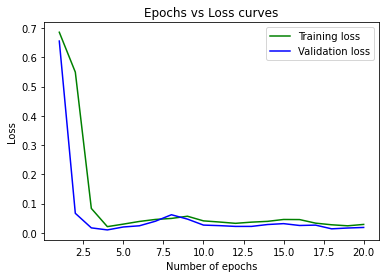

In [ ]:
plt.plot(epochs, train_loss, color = 'green', label = 'Training loss')
plt.plot(epochs, val_loss, color = 'blue', label = 'Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss curves')
plt.legend()
plt.show()

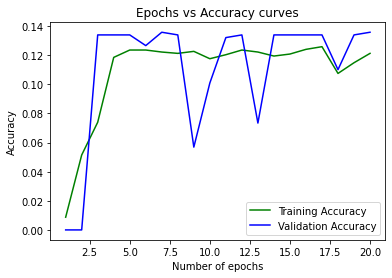

In [ ]:
plt.plot(epochs, train_acc, color = 'green', label = 'Training Accuracy')
plt.plot(epochs, val_acc, color = 'blue', label = 'Validation Accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Epochs vs Accuracy curves')
plt.legend()
plt.show()

In [ ]:
##Extracting test data and creating feature vectors to predict output

num_val = 1000

url_val = []
name_val = []
img_ft_val = []
ques_val = []
ques_ft_val = []
ft_val = []

for vq in test_data[0:num_val]:
  # Extract features describing the image
  image_name = vq['image']
  name_val.append(image_name)
  image_url = img_dir + image_name
  url_val.append(image_url)
  image_feature = extract_image_features(image_url)
  img_ft_val.append(image_feature)

  # Extract features describing the question
  question = vq['question']
  ques_val.append(question)
  question_feature = extract_question_features(question)
  ques_ft_val.append(question_feature)

  # Create a multimodal feature to represent both the image and question (e.g. concatenate, multiply, etc.)
  multimodal_features = np.concatenate((question_feature, image_feature))
  ft_val.append(multimodal_features)


In [ ]:
X_TEST = ft_val

In [ ]:
pred_tets = model.predict(np.array(X_TEST))

In [ ]:
pred_test = list(np.argmax(pred_tets, axis = 1))

In [ ]:
results = []

In [ ]:
for p in pred_test:
  results.append(cols[p])

In [ ]:
df_res = pd.DataFrame(results)
df_res.to_csv("results.csv", header = None, index = None)